<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.959 · Visualització de dades</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Andreu Fornós Bautista</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRÀCTICA ll: Creació de la visualització i lliurament del projecte


## 1. Exploració de les dades

In [1]:
# Primerament importo i instalo les llibreries necessaries
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import HTML
from IPython import display 
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
from skimage import transform
import random
import base64, io
from collections import deque, namedtuple
from pathlib import Path
import seaborn as sns


In [2]:
# Carrego les dades sense index per a usar el temps com a tal
# i en mostro les 5 primeres files
raw_data = pd.read_csv("./Emso_Ligure_Ouest_Albatross_Microcat_CSV_2019_6f0e_7856_e06e.csv")
raw_data.head(5)

,time-UTC,Sensor_serial_number,Sensor_Depth_Theoric-Meter,Temp_insitu-degree_C,Conductivity-S/m,Pressure-dbar,Oxygen-mL/L,depth-meter,Salinity-PSU,Temp_Pot-degree_C,O2_saturation-%,SigmaTheta-kg.m-3
0,2019-07-20T12:29:58Z,3711375,1500,23.3757,0.00013,-0.533,6.111,-0.529,0.011,23.3758,266.4262,-2.5402
1,2019-07-20T12:29:58Z,3711375,1500,23.3757,0.00013,-0.533,6.111,-0.529,0.011,23.3758,266.4262,-2.5402
2,2019-07-20T12:29:58Z,3711375,1500,23.3757,0.00013,-0.533,6.111,-0.529,0.011,23.3758,266.4262,-2.5402
3,2019-07-20T12:29:58Z,3711375,1500,23.3757,0.00013,-0.533,6.111,-0.529,0.011,23.3758,266.4262,-2.5402
4,2019-07-20T12:29:58Z,3711375,1500,23.3757,0.00013,-0.533,6.111,-0.529,0.011,23.3758,266.4262,-2.5402


In [3]:
# Ara, comprobo els tipus de les dades
raw_data.dtypes

time-UTC                       object
Sensor_serial_number            int64
Sensor_Depth_Theoric-Meter      int64
Temp_insitu-degree_C          float64
Conductivity-S/m              float64
Pressure-dbar                 float64
Oxygen-mL/L                   float64
depth-meter                   float64
Salinity-PSU                  float64
Temp_Pot-degree_C             float64
O2_saturation-%               float64
SigmaTheta-kg.m-3             float64
dtype: object

In [4]:
# Com el temps el detecta com un objecte i no com temps, modifico la columna
# per assolir l'objectiu i comprobo que s'ha modificat bé
raw_data['time-UTC'] = pd.to_datetime(raw_data['time-UTC'].str.strip(), format='%Y-%m-%dT%H:%M:%SZ')
raw_data.dtypes

time-UTC                      datetime64[ns]
Sensor_serial_number                   int64
Sensor_Depth_Theoric-Meter             int64
Temp_insitu-degree_C                 float64
Conductivity-S/m                     float64
Pressure-dbar                        float64
Oxygen-mL/L                          float64
depth-meter                          float64
Salinity-PSU                         float64
Temp_Pot-degree_C                    float64
O2_saturation-%                      float64
SigmaTheta-kg.m-3                    float64
dtype: object

In [5]:
# Defineixo una funció que retorna una Serie de Pandas amb el maxim i minim
# de cada columna del dataframe al que se li apliqui
def minMax(x):
    return pd.Series(index=['Valor minim', 'Valor maxim'],data=[x.min(),x.max()])


# Executo la funció
raw_data.apply(minMax)

,time-UTC,Sensor_serial_number,Sensor_Depth_Theoric-Meter,Temp_insitu-degree_C,Conductivity-S/m,Pressure-dbar,Oxygen-mL/L,depth-meter,Salinity-PSU,Temp_Pot-degree_C,O2_saturation-%,SigmaTheta-kg.m-3
Valor minim,2019-07-20 12:29:58,9464,500,13.1594,-0.00004,-0.533,3.707,-0.529,0.00000,12.9087,254.5107,-2.8968
Valor maxim,2020-11-09 23:31:12,3720423,2400,24.8192,4.59945,2399.986,33.573,2367.446,38.69211,24.8192,272.1285,29.1321


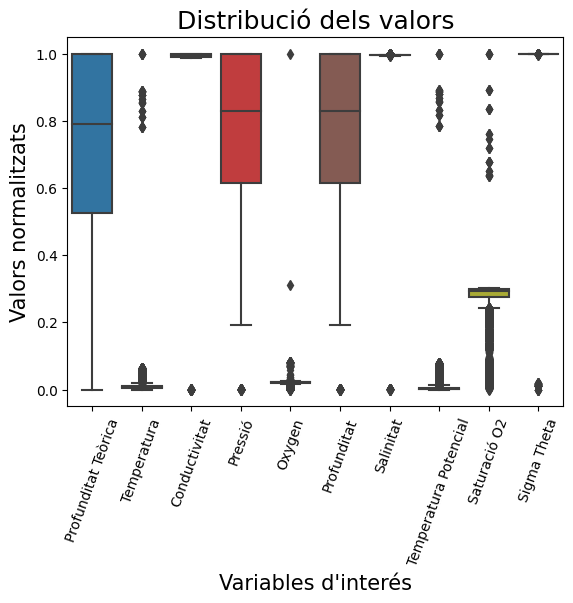

In [6]:
# Pel bé de les visualitzacions, canvio el nom de les columnes
# elimino els valors faltants:
raw_data.columns = ['Data', "Número de Serie", "Profunditat Teòrica", "Temperatura", "Conductivitat", "Pressió", 
                    "Oxygen", "Profunditat", "Salinitat", "Temperatura Potencial", "Saturació O2", "Sigma Theta"]

raw_data = raw_data.dropna()

# Genero una copia de les dades, elimino les columnes de data i número de serie
normalized_data = raw_data.copy()
not_wanted_cols = ['Data', 'Número de Serie']
normalized_data = normalized_data.drop(not_wanted_cols, axis=1)

# Normalitzo les dades
normalized_data = (normalized_data-normalized_data.min())/(normalized_data.max()-normalized_data.min())

# Genero un box plot tot anant modificant-lo per a una millor visualització
boxplot = sns.boxplot(data=normalized_data)
boxplot.tick_params(axis='x', rotation=70)
boxplot.set_ylabel("Valors normalitzats", fontsize= 15)
boxplot.set_xlabel("Variables d'interés", fontsize= 15)
boxplot.set_title("Distribució dels valors", fontsize= 18)

# Guardo i mostro la visualització generada
plt.savefig('visualitzacions/1-BoxPlotExploratori.png')
plt.show()

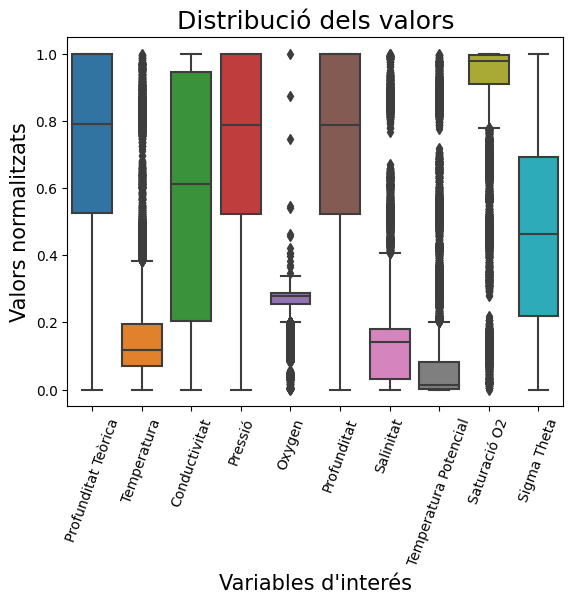

In [7]:
from scipy import stats
from numpy import mean, std


for column in raw_data.columns:
    if column != not_wanted_cols:
        # Primer elimino els valors majors al quanitl 99 i menors al quantil 1
        q_low = raw_data[column].quantile(0.01)
        q_hi  = raw_data[column].quantile(0.99)
        clean_data = raw_data[(raw_data[column] < q_hi) & (raw_data[column] > q_low)]
        
        # Ara calculo la mitja i desviacio estandard per eliminar els valors que s'hen
        # vagin 2 cops aquesta desviació estandard
        data_mean, data_std = mean(clean_data[column]), std(clean_data[column])
        cut_off = data_std * 2
        lower, upper = data_mean - cut_off, data_mean + cut_off
        clean_data = clean_data[(clean_data[column] < upper) & (clean_data[column] > lower)]
        

# Genero una copia de les dades, elimino les columnes de data i número de serie
normalized_data = clean_data.copy()
normalized_data = normalized_data.drop(not_wanted_cols, axis=1)

# Normalitzo les dades
normalized_data = (normalized_data-normalized_data.min())/(normalized_data.max()-normalized_data.min())

# Genero un box plot tot anant modificant-lo per a una millor visualització
boxplot = sns.boxplot(data=normalized_data)
boxplot.tick_params(axis='x', rotation=70)
boxplot.set_ylabel("Valors normalitzats", fontsize= 15)
boxplot.set_xlabel("Variables d'interés", fontsize= 15)
boxplot.set_title("Distribució dels valors", fontsize= 18)

# Guardo i mostro la visualització generada
plt.savefig('visualitzacions/2-BoxPlotDadesNetes.png')
plt.show()

In [8]:
# Resetejo l'index de les dades i elimino les columnes que no
# aporten informació adicional
clean_data = clean_data.reset_index(drop=True)
clean_data = clean_data.drop(["Profunditat Teòrica", "Temperatura Potencial"], axis=1)

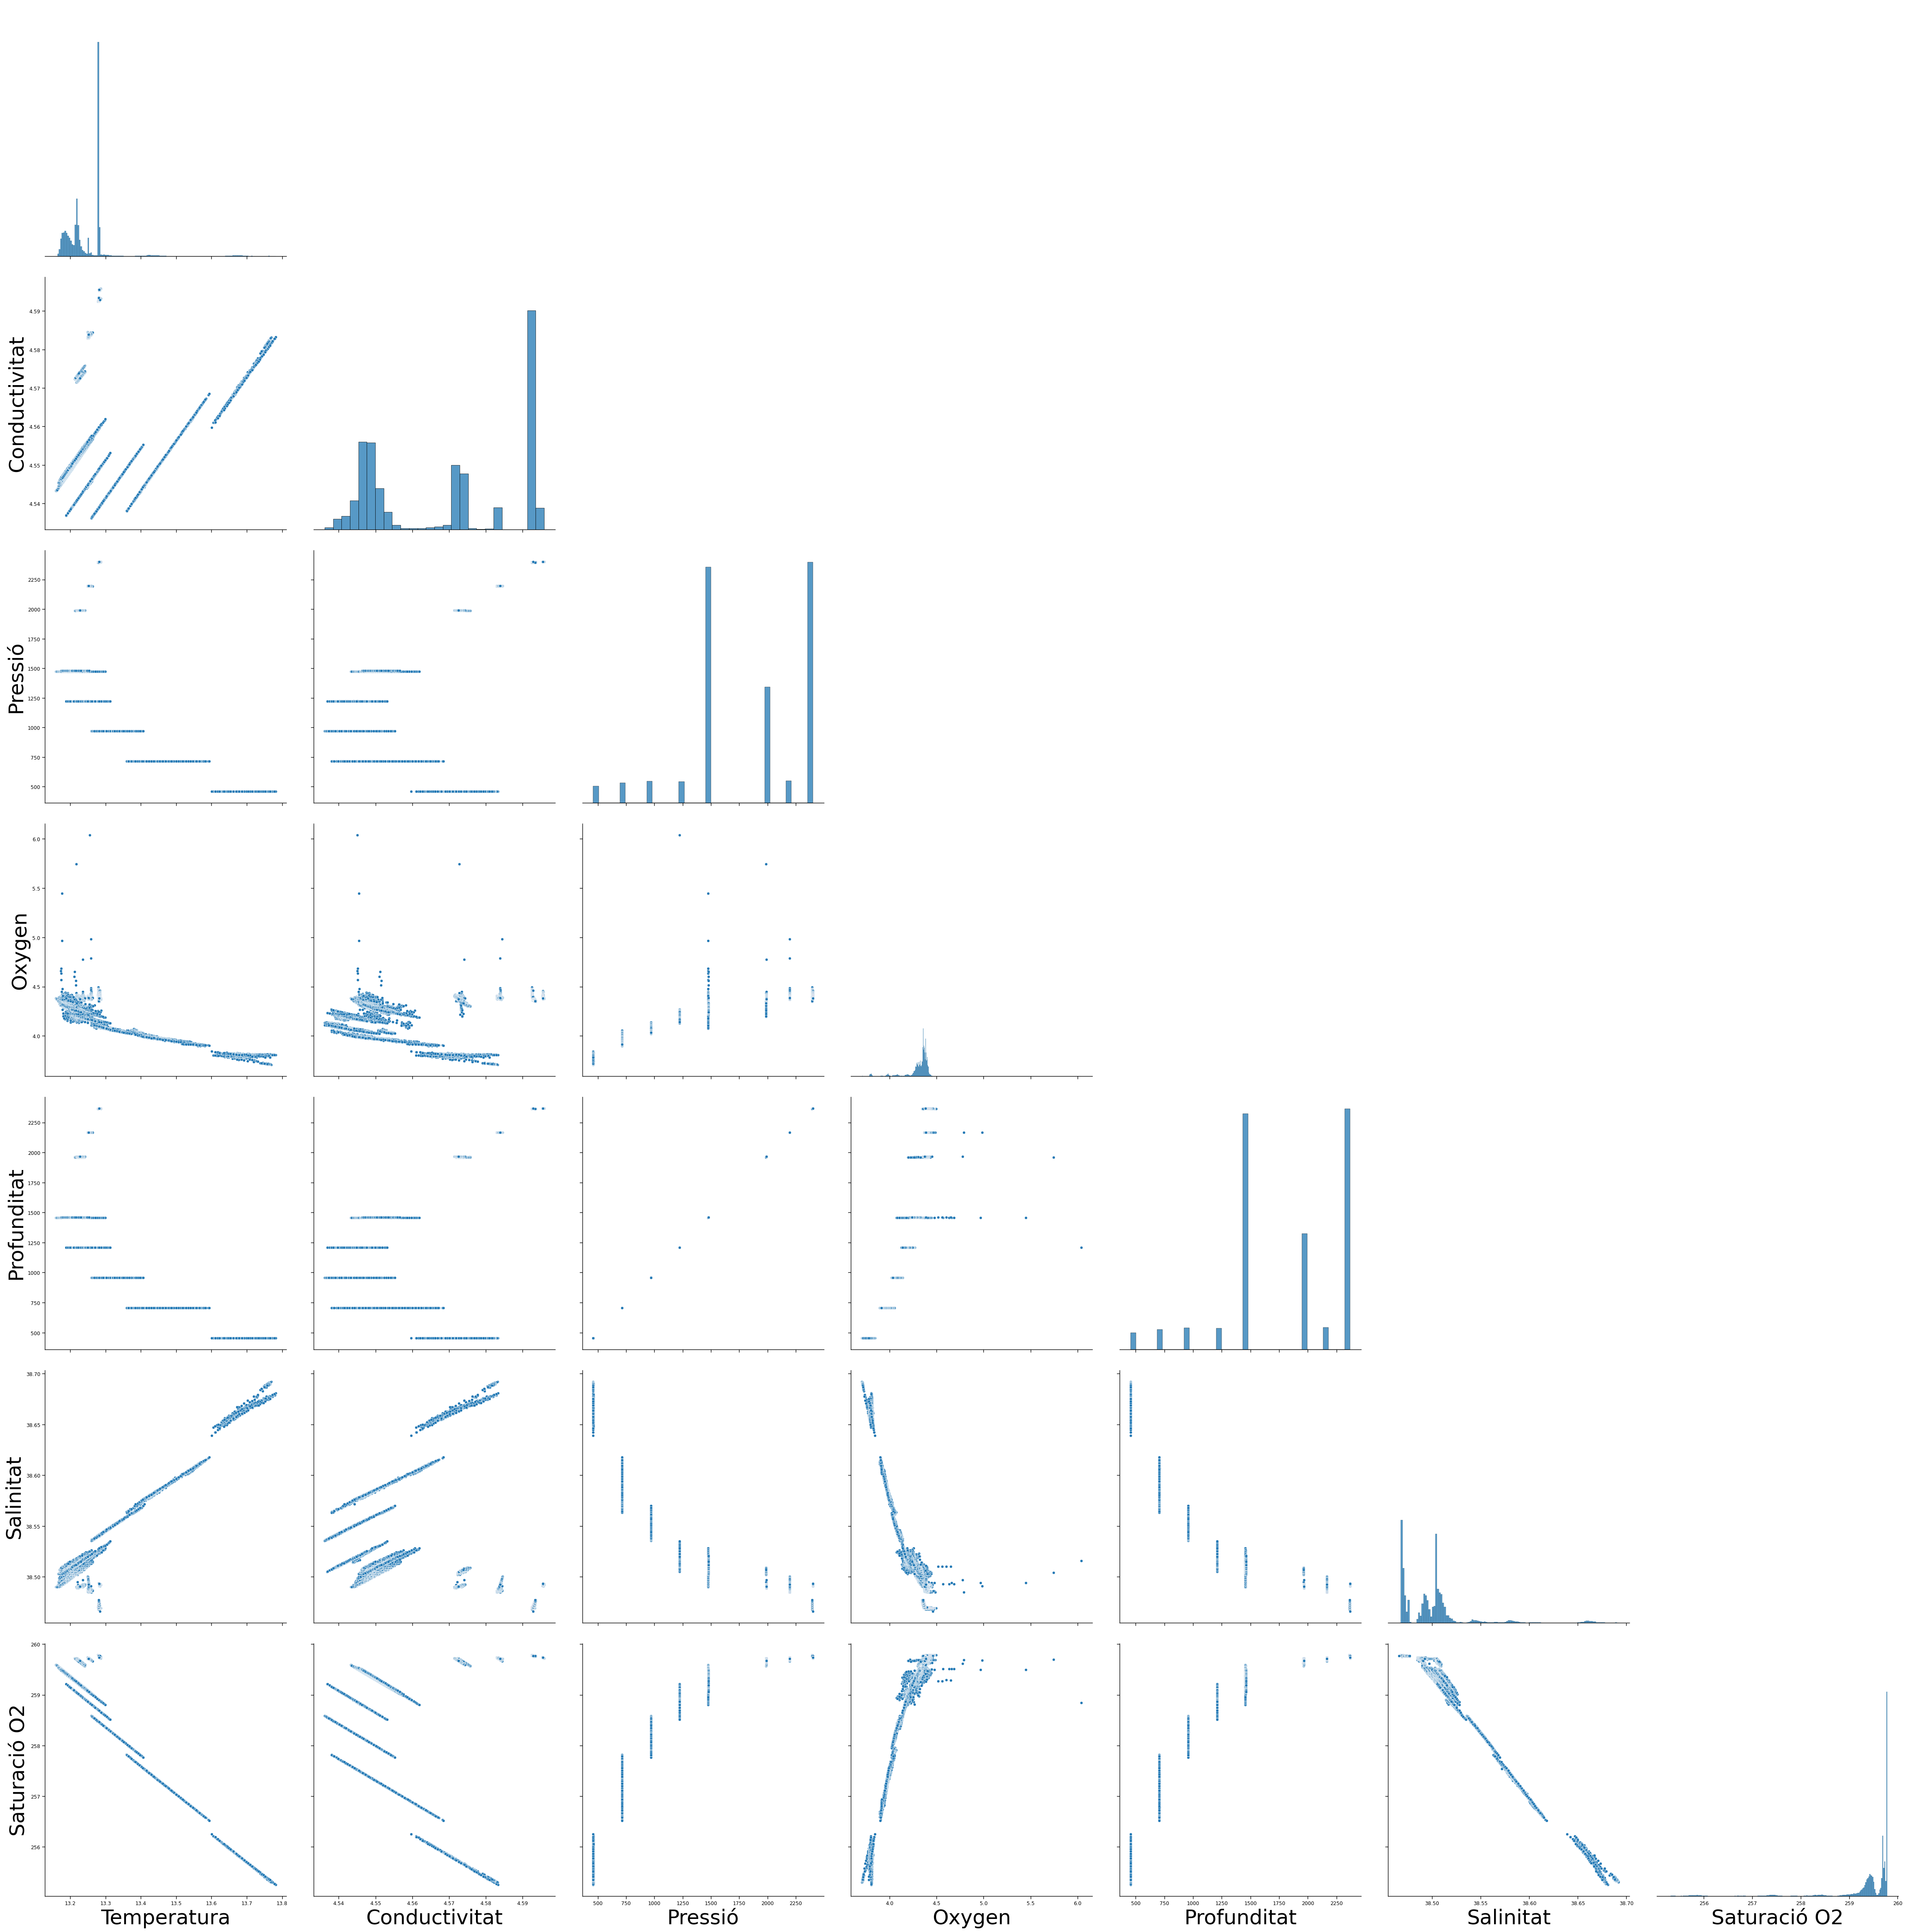

In [9]:
clean_data_pairplot = clean_data.copy()
clean_data_pairplot = clean_data_pairplot.drop(["Número de Serie", "Sigma Theta"], axis=1)

sns.set_context("paper", rc={"axes.labelsize":36})


pairplot = sns.pairplot(clean_data_pairplot, corner=True)
pairplot.map_upper(sns.scatterplot, color='red')
pairplot.fig.set_size_inches(50,50)

plt.savefig('visualitzacions/3-PairPlot.png')
plt.show()

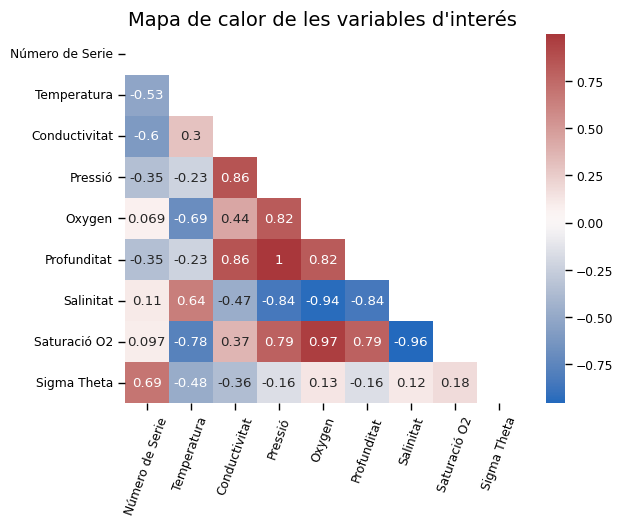

In [10]:
# Calculo la correlacio de les dades
correlacio = clean_data.corr()

# Genero una matriu que farà de mascara amb les correlacions del triangle superior
matrix = np.triu(correlacio)

# Genero un heatmap seguint amb la paleta de colors anterior
heatmap = sns.heatmap(correlacio, mask=matrix, annot=True, cmap="vlag")
heatmap.tick_params(axis='x', rotation=70)

pairplot.fig.set_size_inches(25,25)
plt.title("Mapa de calor de les variables d'interés", fontsize= 14)
plt.savefig('visualitzacions/4-MapaDeCalor.png')
plt.show()

In [11]:
# Creo una copia de les dades normalitzades i em quedo amb les columnes d'interés
bio_profundity_data = normalized_data.copy()
bio_profundity_data = bio_profundity_data.drop(["Profunditat Teòrica", "Temperatura Potencial", 
                                                "Conductivitat", "Pressió", "Saturació O2", "Sigma Theta"], axis=1)
# Canvio la profunditat per la profunditat no normalitzada
bio_profundity_data["Profunditat"] = clean_data["Profunditat"]
# Ordeno el dataframe pel valor de profunditat
bio_profundity_data = bio_profundity_data.sort_values('Profunditat')

In [12]:
profunditat = 450
profunditats = [-0.1]
profunditats_labels = []
while profunditat < 2370:
    profunditats_labels.append(str(profunditat) + ' - ' + str(profunditat + 1))
    profunditat += 1
    profunditats.append(profunditat)
    
    
bio_profundity_data = bio_profundity_data.assign(bins = pd.cut(bio_profundity_data["Profunditat"], 
                                                               profunditats, labels=profunditats_labels))

bio_profundity_data = bio_profundity_data.groupby('bins', as_index=False).mean()
bio_profundity_data = bio_profundity_data.drop(["Profunditat"], axis=1)
bio_profundity_data = bio_profundity_data.dropna()

In [13]:
bio_profundity_data = bio_profundity_data.set_index('bins')
bio_profundity_data = bio_profundity_data.T

In [14]:
import base64
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "clean_data.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [15]:
df = pd.DataFrame(bio_profundity_data, columns=list(bio_profundity_data.keys()))
create_download_link(df, "Descarrega les dades per la quinta visualització", "profundity_data.csv")

La visualització generada amb aquestes dades es pot trobar al seguent enllaç: https://public.flourish.studio/visualisation/12502316

In [16]:
# Faig una copia del dataset amb els dades bones
cummuinity_change_data = clean_data.copy()
# Creo una columna amb el mes
cummuinity_change_data['month'] = pd.DatetimeIndex(cummuinity_change_data['Data']).month
# Ara procedeixo a quedar-me amb un dataset que contingui
# la profunditat, la concentració en O2 i el mes:
cummuinity_change_data = cummuinity_change_data.drop(["Data", "Número de Serie", "Temperatura", "Conductivitat", "Pressió", 
                                                      "Salinitat", "Saturació O2", "Sigma Theta"], axis=1)

cummuinity_change_data.head()

,Oxygen,Profunditat,month
0,5.447,1456.382,8
1,4.966,1456.394,8
2,4.448,1456.370,8
3,4.686,1456.382,8
4,4.635,1456.394,8


In [17]:
# Compartimento la profunditat
cummuinity_change_data = cummuinity_change_data.assign(bins = pd.cut(cummuinity_change_data["Profunditat"], 
                                                               profunditats, labels=profunditats_labels))

# ELimino la columna de profunditat i les files amb valors nuls
cummuinity_change_data = cummuinity_change_data.drop(["Profunditat"], axis=1)
cummuinity_change_data = cummuinity_change_data.dropna()

# Ordeno el dataframe pel valor de mes
cummuinity_change_data = cummuinity_change_data.sort_values('month')
# Agrupo les dades per mes i profunditat i elimino les files amb valors nulls
cummuinity_change_data = cummuinity_change_data.groupby(['month', "bins"], as_index=False).mean()
cummuinity_change_data = cummuinity_change_data.dropna()

In [18]:
# Ordeno el dataframe pel valor de mes
cummuinity_change_data = cummuinity_change_data.sort_values('bins')
cummuinity_change_data["Oxygen"] = (cummuinity_change_data["Oxygen"]-cummuinity_change_data["Oxygen"].min())/(cummuinity_change_data["Oxygen"].max()-cummuinity_change_data["Oxygen"].min())

df = pd.DataFrame(cummuinity_change_data, columns=list(cummuinity_change_data.keys()))
create_download_link(df, "Descarrega les dades per la sexta visualització", "cummuinity_change_data.csv")

In [19]:
# Faig una copia del dataset amb els dades bones
sensors_data = clean_data.copy()

# Selecciono només les columnes conflictives
sensors_data = sensors_data.drop(["Conductivitat", "Pressió", "Sigma Theta"], axis=1)
# Creo una columna amb el mes
sensors_data['month'] = pd.DatetimeIndex(sensors_data['Data']).month
sensors_data = sensors_data.drop(["Data"], axis=1)

# Compartimento la profunditat
sensors_data = sensors_data.assign(bins = pd.cut(sensors_data["Profunditat"],
                                                 profunditats, labels=profunditats_labels))

# ELimino la columna de profunditat i les files amb valors nuls
sensors_data = sensors_data.drop(["Profunditat"], axis=1)
sensors_data = sensors_data.dropna()


sensors_data = sensors_data.groupby(['Número de Serie', "month", "bins"], as_index=False).mean()
sensors_data = sensors_data.dropna()

In [20]:
sensors_data = sensors_data.sort_values('bins')
sensors_data.head(100)

,Número de Serie,month,bins,Temperatura,Oxygen,Salinitat,Saturació O2
17284,10024,10,454 - 455,13.716333,3.766778,38.672066,255.601144
19204,10024,11,454 - 455,13.682057,3.803929,38.661968,255.793129
17285,10024,10,455 - 456,13.686468,3.795796,38.663816,255.767802
19205,10024,11,455 - 456,13.673819,3.808517,38.660228,255.838386
292096,3713016,9,706 - 707,13.545108,3.924263,38.604757,256.788239
...,...,...,...,...,...,...,...
140152,16360,1,2362 - 2363,13.280125,4.386192,38.469034,259.780657
155517,16360,9,2367 - 2368,13.282877,4.408463,38.491735,259.734048
157437,16360,10,2367 - 2368,13.282014,4.394342,38.492140,259.737934
362877,3716360,9,2367 - 2368,13.283343,4.419265,38.491612,259.731763


In [21]:
df = pd.DataFrame(cummuinity_change_data, columns=list(cummuinity_change_data.keys()))
create_download_link(df, "Descarrega les dades per la sèptima visualització", "sensor_data.csv")